In [1]:
import json
from pathlib import Path
import numpy as np
from brian2 import *
import matplotlib.pyplot as plt

In [2]:
# entropy calculation
from entropy.entropy import EntropyCalculator
entropy_calculator = EntropyCalculator()
def mi_matrix(output_spikes, input_spikes):
    """
    Calculate the mutual information of the model.
    Calculation includes the MI for each output neuron and the overall MI of the model.
    
    Formula: I(S;R) = ∑p(s,r) log(p(s,r)/(p(s)p(r)))
    
    where:
        - S is the input spikes
        - R is the output spikes
        - p(s,r) is the joint probability of input and output spikes
        - p(s) is the marginal probability of input spikes
        - p(r) is the marginal probability of output spikes

    Args:
        output_spikes (list): Spikes from the output layer.
        input_spikes (list): Spikes from the input layer.

    Returns:
        np.ndarray: List of MI (neuron0, neuron1, overall).
    """
    output_spikes = np.array(output_spikes)
    input_spikes = np.array(input_spikes)

    mi = []

    for input_spike in input_spikes:
        if not isinstance(input_spike, np.ndarray):
            raise ValueError("Input spikes must be a numpy array.")
        
        for output_spike in output_spikes:
            if not isinstance(output_spike, np.ndarray):
                raise ValueError("Output spikes must be a numpy array.")
            mi.append(entropy_calculator.mutual_information(input_spike, output_spike))

    return np.mean(np.asarray(mi), axis=0)

def hc_matrix(output_spikes, input_spikes):
    """
    Calculate the conditional entropy of the model.
    Calculation includes the conditional entropy for each output neuron and the overall conditional entropy of the model.
    
    Formula: H(R|S) = -∑p(s)∑p(r|s) log(p(r|s))
    
    Args:
        output_spikes (list): Spikes from the output layer.
        input_spikes (list): Spikes from the input layer.

    Returns:
        np.ndarray: List of entropies (neuron0, neuron1, overall).
    """
    output_spikes = np.array(output_spikes)
    input_spikes = np.array(input_spikes)
    
    hc = []
    
    for input_spike in input_spikes:
        if not isinstance(input_spike, np.ndarray):
            raise ValueError("Input spikes must be a numpy array.")

        for output_spike in output_spikes:
            if not isinstance(output_spike, np.ndarray):
                raise ValueError("Output spikes must be a numpy array.")

            hc.append(entropy_calculator.conditional_entropy(output_spike, input_spike))

    return np.mean(np.asarray(hc), axis=0)

In [ ]:
def load_npz_folder(folder, x_key="spike_matrix", label_key="label", C=None, T=None, strict=False):
    folder = Path(folder); files = sorted(folder.glob("*.npz"))
    if not files: raise FileNotFoundError(f"No .npz in {folder}")
    X, y = [], []
    for f in files:
        data = np.load(f, allow_pickle=False)
        if x_key not in data or label_key not in data:
            print(f"[WARN] Skip {f.name}: missing keys"); continue
        x = data[x_key]; lbl = data[label_key]
        lbl = int(lbl) if not isinstance(lbl, np.ndarray) else int(np.ravel(lbl)[0])
        if x.ndim != 2: 
            print(f"[WARN] Skip {f.name}: x must be 2D (C,T), got {x.shape}"); continue
        Cx, Tx = x.shape
        if strict and ((C is not None and Cx != C) or (T is not None and Tx != T)):
            print(f"[WARN] Skip {f.name}: expected ({C},{T}), got {x.shape}"); continue
        X.append(x.astype(np.int8)); y.append(lbl)
    if not X: raise RuntimeError("No valid samples loaded.")
    X, y = np.array(X, dtype=np.int8), np.array(y, dtype=int)
    if C is None or T is None: C, T = X.shape[1], X.shape[2]
    return X, y, int(C), int(T)

def spikes_from_matrix(binmat, dt_ms):
    ch, t = np.where(binmat > 0)
    if ch.size == 0: return np.array([], dtype=int), np.array([], dtype=float)
    times_ms = (t.astype(np.float64) * dt_ms)
    return ch.astype(int), times_ms

def make_balanced_splits(y, train_split, val_split, balance_val, rng):
    n = len(y)
    idx0 = np.where(y==0)[0]
    idx1 = np.where(y==1)[0]
    rng.shuffle(idx0); rng.shuffle(idx1)

    # desired validation size
    n_val_total = int(np.floor(val_split * n))
    if balance_val:
        n_val_per = min(len(idx0), len(idx1), n_val_total//2)
        val_idx = np.concatenate([idx0[:n_val_per], idx1[:n_val_per]])
        idx0 = idx0[n_val_per:]; idx1 = idx1[n_val_per:]
    else:
        n_val0 = int(round(n_val_total * len(idx0)/(len(idx0)+len(idx1))))
        n_val1 = n_val_total - n_val0
        val_idx = np.concatenate([idx0[:n_val0], idx1[:n_val1]])
        idx0 = idx0[n_val0:]; idx1 = idx1[n_val1:]

    remaining = np.concatenate([idx0, idx1])
    rng.shuffle(remaining)

    n_train_total = int(np.floor(train_split * n))
    n_train_total = min(n_train_total, len(remaining))
    train_idx = remaining[:n_train_total]
    rest = remaining[n_train_total:]

    rng.shuffle(train_idx); rng.shuffle(val_idx)
    return train_idx.astype(int), val_idx.astype(int)

def predict_spike_count(counts):
    return int(np.argmax(counts))

def build_network(C, dt_ms, params):
    K = params['out_k']; Nout = 2 * K
    defaultclock.dt = dt_ms * ms
    G_in = SpikeGeneratorGroup(C, indices=np.array([], dtype=int), times=np.array([])*ms, name='G_in')
    eqs = '''
    dv/dt = (-v + ge - gi) / tau_m : 1 (unless refractory)
    dge/dt = -ge / tau_e : 1
    dgi/dt = -gi / tau_i : 1
    tau_m : second
    tau_e : second
    tau_i : second
    v_th : 1
    '''
    G_out = NeuronGroup(Nout, eqs, threshold='v>v_th', reset='v=0',
                        refractory=params['refractory']*ms, method='euler', name='outpop')
    G_out.tau_m = params['tau_mem'] * ms
    G_out.tau_e = params['tau_syn'] * ms
    G_out.tau_i = params['inh_tau'] * ms
    G_out.v_th = params['v_th']; G_out.v = 0

    S = Synapses(G_in, G_out,
                 model='''
                 w : 1
                 dxpre/dt = -xpre/taupre : 1 (clock-driven)
                 dxpost/dt = -xpost/taupost : 1 (clock-driven)
                 taupre : second
                 taupost : second
                 Aplus : 1
                 Aminus : 1
                 eta : 1
                 wmax : 1
                 ''',
                 on_pre='''
                 ge_post += w
                 xpre += Aplus
                 w = clip(w + eta * xpost, 0, wmax)
                 ''',
                 on_post='''
                 xpost += Aminus
                 w = clip(w - eta * xpre, 0, wmax)
                 ''',
                 name='S_in_out')
    S.connect(True)
    rng = np.random.default_rng(params['seed'])
    S.w = rng.uniform(0.0, 0.3, size=len(S))
    S.taupre = params['tau_pre'] * ms
    S.taupost = params['tau_post'] * ms
    S.Aplus = params['Aplus']; S.Aminus = params['Aminus']
    S.eta = params['lr']; S.wmax = params['wmax']

    S_inh = Synapses(G_out, G_out, on_pre='gi_post += w_inh', model='w_inh:1', name='S_lateral_inh')
    S_inh.connect(condition='i!=j'); S_inh.w_inh = params['inh_w']

    M_out = SpikeMonitor(G_out, name='M_out')
    net = Network(G_in, G_out, S, S_inh, M_out)
    return net, G_in, G_out, S, M_out, K

def class_counts_by_mapping(M_out, t_start, t_end, mapping, Nout):
    mask = (M_out.t/ms >= t_start) & (M_out.t/ms < t_end)
    ids = np.array(M_out.i[mask], dtype=int)
    if ids.size == 0: return [0, 0]
    cls_ids = mapping[ids]
    c0 = int(np.sum(cls_ids == 0)); c1 = int(np.sum(cls_ids == 1))
    return [c0, c1]

def per_neuron_hist(M_out, t_start, t_end, Nout):
    mask = (M_out.t/ms >= t_start) & (M_out.t/ms < t_end)
    ids = np.array(M_out.i[mask], dtype=int)
    if ids.size == 0: return np.zeros(Nout, dtype=int)
    return np.bincount(ids, minlength=Nout).astype(int)

def train_and_eval(X, y, C, T, params):
    dt_ms = float(params['dt'])
    Tdur_ms = T * dt_ms
    gap_ms = float(params['gap'])
    rng = np.random.default_rng(params['seed'])
    
    train_idx, val_idx = make_balanced_splits(y, params['train_split'], params['val_split'], True, rng)

    net, G_in, G_out, S, M_out, K = build_network(C, dt_ms, params)
    Nout = 2 * K

    def normalize_per_post():
        if not params['norm_per_post']: return
        for j in range(Nout):
            idx_j = np.where(S.j[:] == j)[0]
            if idx_j.size > 0:
                s = float(np.sum(S.w[idx_j]))
                if s > 0: S.w[idx_j] = S.w[idx_j] / s

    def run_trial(binmat, learn=True):
        S.eta = params['lr'] if learn else 0.0
        t_now = float(defaultclock.t/ms)
        inds, times_ms = spikes_from_matrix(binmat, dt_ms)
        G_in.set_spikes(inds, (t_now + times_ms) * ms)
        G_out.v = 0
        G_out.ge = 0
        G_out.gi = 0
        t_start = t_now
        t_end = t_now + Tdur_ms
        net.run((Tdur_ms + gap_ms) * ms, report=None)
        return t_start, t_end

    def build_label_mapping(indices):
        counts = np.zeros((Nout, 2), dtype=int)
        for i in indices:
            binmat, label = X[i], int(y[i])
            t_start, t_end = run_trial(binmat, learn=False)
            hist = per_neuron_hist(M_out, t_start, t_end, Nout)
            counts[:, label] += hist
        mapping = np.where(counts[:,1] > counts[:,0], 1, 0).astype(int)
        return mapping
    
    val_acc_hist = []
    entropy_hist = {
        "group_0": {
            "shannon_entropy": [],
            "entropy_rate": [],
            "mutual_information": [],
            "conditional_entropy": [],
            "avg_spike_count": []
            },
        "group_1": {
            "shannon_entropy": [],
            "entropy_rate": [],
            "mutual_information": [],
            "conditional_entropy": [],
            "avg_spike_count": []
            },
        "model": {
            "shannon_entropy": [],
            "entropy_rate": [],
            "mutual_information": [],
            "conditional_entropy": [],
            "avg_spike_count": []
        }
    }

    for ep in range(params['epochs']):
        if params["epoch_samples"] and params["epoch_samples"] > 0:
            idx0 = train_idx[y[train_idx] == 0]
            idx1 = train_idx[y[train_idx] == 1]

            m = min(params["epoch_samples"] // 2, len(idx0), len(idx1))
            ep_idx = np.concatenate([rng.choice(idx0, m, replace=False), rng.choice(idx1, m, replace=False)])
            
            rng.shuffle(ep_idx)
        else:
            ep_idx = train_idx.copy()
            rng.shuffle(ep_idx)
        
        for i in ep_idx:
            binmat = X[i]
            run_trial(binmat, learn=True)
            normalize_per_post()

        mapping = build_label_mapping(ep_idx)

        val_correct = 0
        val_total = 0
        val_entropy = {
            "group_0": {
                "shannon_entropy": [],
                "entropy_rate": [],
                "mutual_information": [],
                "conditional_entropy": [],
                "spike_count": []
            },
            "group_1": {
                "shannon_entropy": [],
                "entropy_rate": [],
                "mutual_information": [],
                "conditional_entropy": [],
                "spike_count": []
            },
            "model": {
                "shannon_entropy": [],
                "entropy_rate": [],
                "mutual_information": [],
                "conditional_entropy": [],
                "spike_count": []
            }
        }
        for i_val in val_idx:
            binmat_v, label_v = X[i_val], int(y[i_val])
            t_start, t_end = run_trial(binmat_v, learn=False)
            counts_v = class_counts_by_mapping(M_out, t_start, t_end, mapping, Nout)
            y_pred_v = int(np.argmax(counts_v)); val_correct += int(y_pred_v == label_v); val_total += 1
            
            mask = (M_out.t/ms >= t_start) & (M_out.t/ms < t_end)
            out_neuron = np.array(M_out.i[mask], dtype=int)
            out_t_ms = np.array((M_out.t[mask]/ms) - t_start, dtype=float)
            
            bins = np.floor(out_t_ms / dt_ms).astype(int)
            bins = np.clip(bins, 0, T-1)
            out_spike = np.zeros((Nout, T), dtype=int)
            np.add.at(out_spike, (out_neuron, bins), 1)
            out_spike = (out_spike > 0).astype(int)
            
            out_spike0 = out_spike[0:K, :]
            val_entropy["group_0"]["shannon_entropy"].append(entropy_calculator.shannon_entropy(out_spike0))
            val_entropy["group_0"]["entropy_rate"].append(entropy_calculator.entropy_rate(out_spike0))
            val_entropy["group_0"]["mutual_information"].append(mi_matrix(out_spike0, binmat_v))
            val_entropy["group_0"]["conditional_entropy"].append(hc_matrix(out_spike0, binmat_v))
            val_entropy["group_0"]["spike_count"].append(np.sum(out_spike0))
            
            out_spike1 = out_spike[K:Nout, :]
            val_entropy["group_1"]["shannon_entropy"].append(entropy_calculator.shannon_entropy(out_spike1))
            val_entropy["group_1"]["entropy_rate"].append(entropy_calculator.entropy_rate(out_spike1))
            val_entropy["group_1"]["mutual_information"].append(mi_matrix(out_spike1, binmat_v))
            val_entropy["group_1"]["conditional_entropy"].append(hc_matrix(out_spike1, binmat_v))
            val_entropy["group_1"]["spike_count"].append(np.sum(out_spike1))

            val_entropy["model"]["shannon_entropy"].append(entropy_calculator.shannon_entropy(out_spike))
            val_entropy["model"]["entropy_rate"].append(entropy_calculator.entropy_rate(out_spike))
            val_entropy["model"]["mutual_information"].append(mi_matrix(out_spike, binmat_v))
            val_entropy["model"]["conditional_entropy"].append(hc_matrix(out_spike, binmat_v))
            val_entropy["model"]["spike_count"].append(np.sum(out_spike))

        val_acc = val_correct / max(1, val_total)
        val_acc_hist.append(val_acc)
        entropy_hist["group_0"]["shannon_entropy"].append(np.mean(val_entropy["group_0"]["shannon_entropy"]))
        entropy_hist["group_0"]["entropy_rate"].append(np.mean(val_entropy["group_0"]["entropy_rate"]))
        entropy_hist["group_0"]["mutual_information"].append(np.mean(val_entropy["group_0"]["mutual_information"]))
        entropy_hist["group_0"]["conditional_entropy"].append(np.mean(val_entropy["group_0"]["conditional_entropy"]))
        entropy_hist["group_0"]["avg_spike_count"].append(np.mean(val_entropy["group_0"]["spike_count"]))
        
        entropy_hist["group_1"]["shannon_entropy"].append(np.mean(val_entropy["group_1"]["shannon_entropy"]))
        entropy_hist["group_1"]["entropy_rate"].append(np.mean(val_entropy["group_1"]["entropy_rate"]))
        entropy_hist["group_1"]["mutual_information"].append(np.mean(val_entropy["group_1"]["mutual_information"]))
        entropy_hist["group_1"]["conditional_entropy"].append(np.mean(val_entropy["group_1"]["conditional_entropy"]))
        entropy_hist["group_1"]["avg_spike_count"].append(np.mean(val_entropy["group_1"]["spike_count"]))

        entropy_hist["model"]["shannon_entropy"].append(np.mean(val_entropy["model"]["shannon_entropy"]))
        entropy_hist["model"]["entropy_rate"].append(np.mean(val_entropy["model"]["entropy_rate"]))
        entropy_hist["model"]["mutual_information"].append(np.mean(val_entropy["model"]["mutual_information"]))
        entropy_hist["model"]["conditional_entropy"].append(np.mean(val_entropy["model"]["conditional_entropy"]))
        entropy_hist["model"]["avg_spike_count"].append(np.mean(val_entropy["model"]["spike_count"]))

        print(f"[Epoch {ep+1}/{params['epochs']}] Val acc: {val_acc:.3f} on {val_total} samples")

    final_mapping = build_label_mapping(train_idx)

    return {"val_acc_hist": val_acc_hist if val_acc_hist else None,
            "entropy_hist": entropy_hist if entropy_hist else None,
            "n_train": int(len(train_idx)), "n_val": int(len(val_idx))}, S, K

In [27]:
params = {
    "NPZ_DIR": Path("/Users/minhhieunguyen/Documents/Projects/Dissertation/Code/spike_data/ch32"),
    "x_key": "spike_matrix",
    "label_key": "label",
    "channels": 32,
    "time": 100,
    "strict_shape": True,
    "dt": 1.0,
    "epochs": 15,
    "seed": 42,
    "gap": 25.0,
    "out_k": 10,
    "v_th": 0.55,
    "tau_mem": 20.0,
    "tau_syn": 12,
    "inh_tau": 10,
    "refractory": 5.0,
    "inh_w": 2.2,
    "lr": 0.005,
    "Aplus": 1.0,
    "Aminus": 1.0,
    "tau_pre": 80,
    "tau_post": 80,
    "wmax": 2.0,
    "norm_per_post": True,
    "train_split": 0.85,
    "val_split": 0.15,
    "epoch_samples": 128
}

In [28]:
X, y, C, T = load_npz_folder(params["NPZ_DIR"], params["x_key"], params["label_key"],
                                 C=params["channels"], T=params["time"], strict=params["strict_shape"])
print(f"Loaded {len(X)} samples, shape = ({C},{T}), labels 0/1")
prefs.codegen.target = 'numpy'
metrics, S, K = train_and_eval(X, y, C, T, params)
print(metrics)

Loaded 400 samples, shape = (32,100), labels 0/1
[Epoch 1/15] Val acc: 0.567 on 60 samples
[Epoch 2/15] Val acc: 0.600 on 60 samples
[Epoch 3/15] Val acc: 0.567 on 60 samples
[Epoch 4/15] Val acc: 0.700 on 60 samples
[Epoch 5/15] Val acc: 0.533 on 60 samples
[Epoch 6/15] Val acc: 0.650 on 60 samples
[Epoch 7/15] Val acc: 0.683 on 60 samples
[Epoch 8/15] Val acc: 0.600 on 60 samples
[Epoch 9/15] Val acc: 0.650 on 60 samples
[Epoch 10/15] Val acc: 0.500 on 60 samples
[Epoch 11/15] Val acc: 0.700 on 60 samples
[Epoch 12/15] Val acc: 0.700 on 60 samples
[Epoch 13/15] Val acc: 0.583 on 60 samples
[Epoch 14/15] Val acc: 0.700 on 60 samples
[Epoch 15/15] Val acc: 0.717 on 60 samples
{'val_acc_hist': [0.5666666666666667, 0.6, 0.5666666666666667, 0.7, 0.5333333333333333, 0.65, 0.6833333333333333, 0.6, 0.65, 0.5, 0.7, 0.7, 0.5833333333333334, 0.7, 0.7166666666666667], 'entropy_hist': {'group_0': {'shannon_entropy': [0.031569168720335807, 0.025870153948987628, 0.027244307098388473, 0.037571116247

In [29]:
val_acc_hist = metrics["val_acc_hist"]
group0_shannon_entropy = metrics["entropy_hist"]["group_0"]["shannon_entropy"]
group0_entropy_rate = metrics["entropy_hist"]["group_0"]["entropy_rate"]
group0_mutual_information = metrics["entropy_hist"]["group_0"]["mutual_information"]
group0_conditional_entropy = metrics["entropy_hist"]["group_0"]["conditional_entropy"]
group0_avg_spike_count = metrics["entropy_hist"]["group_0"]["avg_spike_count"]

group1_shannon_entropy = metrics["entropy_hist"]["group_1"]["shannon_entropy"]
group1_entropy_rate = metrics["entropy_hist"]["group_1"]["entropy_rate"]
group1_mutual_information = metrics["entropy_hist"]["group_1"]["mutual_information"]
group1_conditional_entropy = metrics["entropy_hist"]["group_1"]["conditional_entropy"]
group1_avg_spike_count = metrics["entropy_hist"]["group_1"]["avg_spike_count"]

model_shannon_entropy = metrics["entropy_hist"]["model"]["shannon_entropy"]
model_entropy_rate = metrics["entropy_hist"]["model"]["entropy_rate"]
model_mutual_information = metrics["entropy_hist"]["model"]["mutual_information"]
model_conditional_entropy = metrics["entropy_hist"]["model"]["conditional_entropy"]
model_avg_spike_count = metrics["entropy_hist"]["model"]["avg_spike_count"]

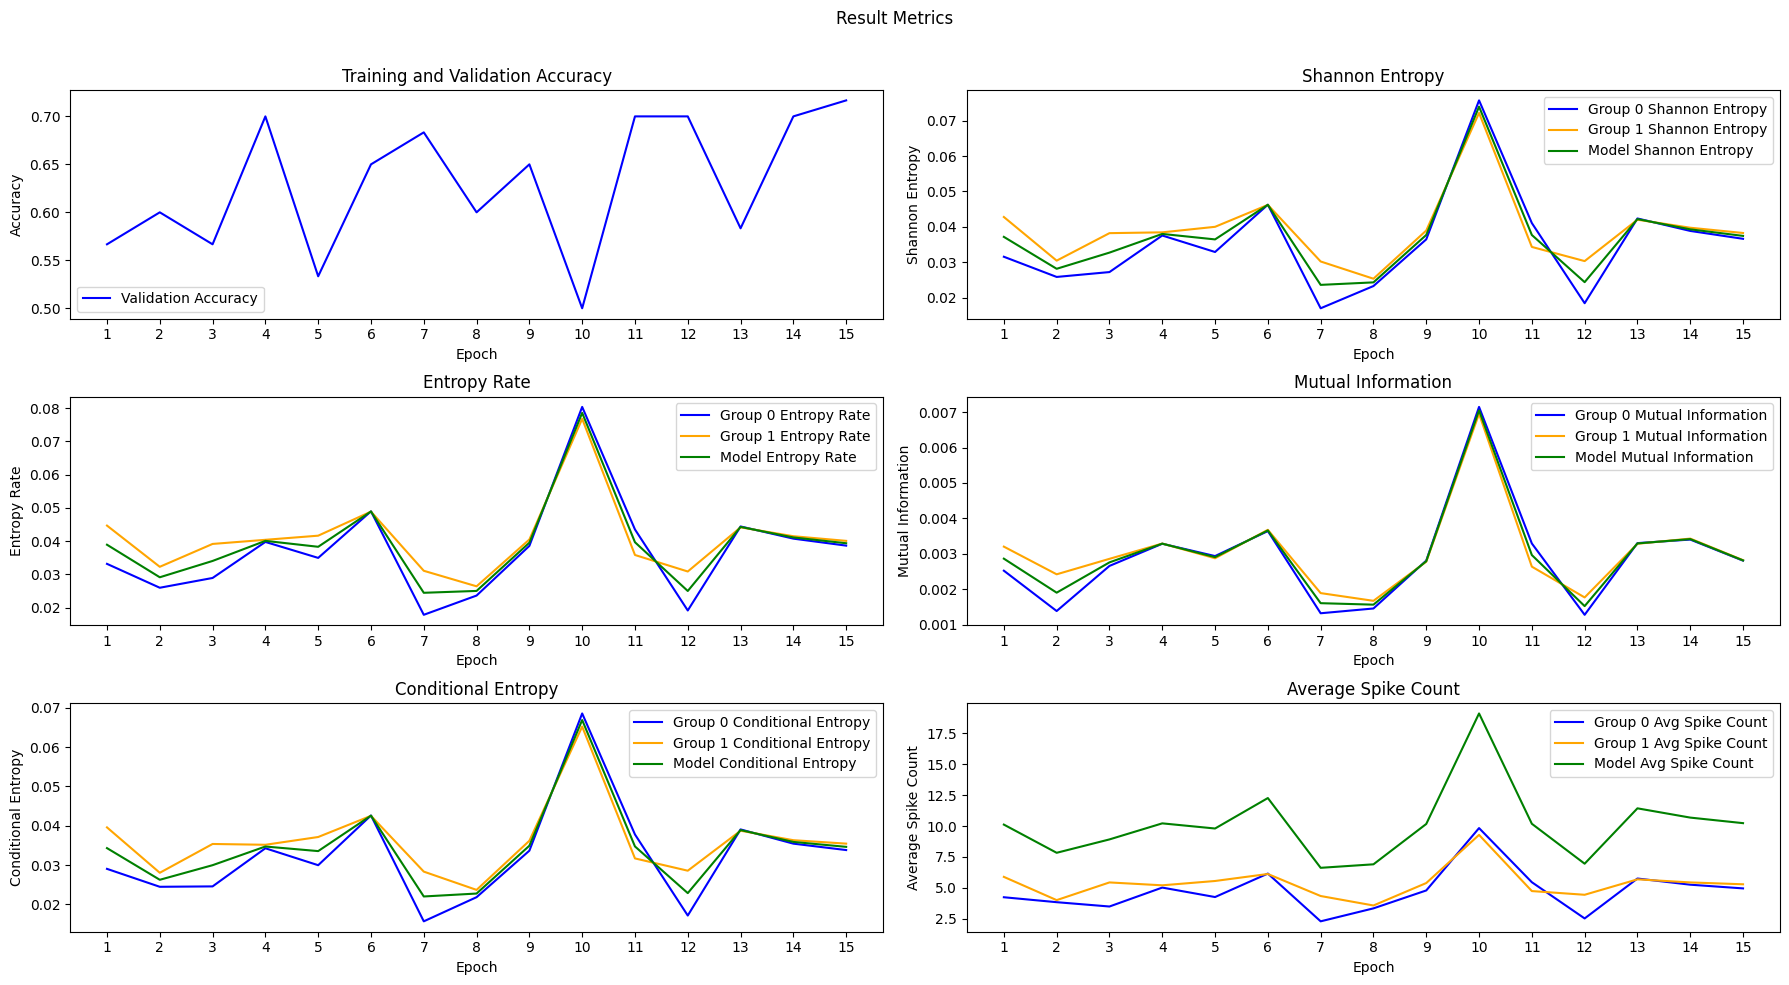

In [30]:
epoch_axis = np.arange(1, params["epochs"] + 1, 1)

# Plot the model results
plt.figure(figsize=(18, 10))

plt.subplot(3, 2, 1)
plt.plot(epoch_axis, val_acc_hist, label='Validation Accuracy', color='blue')
plt.xticks(np.arange(1, params["epochs"] + 1, 1))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(epoch_axis, group0_shannon_entropy, label='Group 0 Shannon Entropy', color='blue')
plt.plot(epoch_axis, group1_shannon_entropy, label='Group 1 Shannon Entropy', color='orange')
plt.plot(epoch_axis, model_shannon_entropy, label='Model Shannon Entropy', color='green')
plt.xticks(np.arange(1, params["epochs"] + 1, 1))
plt.xlabel('Epoch')
plt.ylabel('Shannon Entropy')
plt.title('Shannon Entropy')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(epoch_axis, group0_entropy_rate, label='Group 0 Entropy Rate', color='blue')
plt.plot(epoch_axis, group1_entropy_rate, label='Group 1 Entropy Rate', color='orange')
plt.plot(epoch_axis, model_entropy_rate, label='Model Entropy Rate', color='green')
plt.xticks(np.arange(1, params["epochs"] + 1, 1))
plt.xlabel('Epoch')
plt.ylabel('Entropy Rate')
plt.title('Entropy Rate')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(epoch_axis, group0_mutual_information, label='Group 0 Mutual Information', color='blue')
plt.plot(epoch_axis, group1_mutual_information, label='Group 1 Mutual Information', color='orange')
plt.plot(epoch_axis, model_mutual_information, label='Model Mutual Information', color='green')
plt.xticks(np.arange(1, params["epochs"] + 1, 1))
plt.xlabel('Epoch')
plt.ylabel('Mutual Information')
plt.title('Mutual Information')
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(epoch_axis, group0_conditional_entropy, label='Group 0 Conditional Entropy', color='blue')
plt.plot(epoch_axis, group1_conditional_entropy, label='Group 1 Conditional Entropy', color='orange')
plt.plot(epoch_axis, model_conditional_entropy, label='Model Conditional Entropy', color='green')
plt.xticks(np.arange(1, params["epochs"] + 1, 1))
plt.xlabel('Epoch')
plt.ylabel('Conditional Entropy')
plt.title('Conditional Entropy')
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(epoch_axis, group0_avg_spike_count, label='Group 0 Avg Spike Count', color='blue')
plt.plot(epoch_axis, group1_avg_spike_count, label='Group 1 Avg Spike Count', color='orange')
plt.plot(epoch_axis, model_avg_spike_count, label='Model Avg Spike Count', color='green')
plt.xticks(np.arange(1, params["epochs"] + 1, 1))
plt.xlabel('Epoch')
plt.ylabel('Average Spike Count')
plt.title('Average Spike Count')
plt.legend()

plt.suptitle('Result Metrics')
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()